In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import torch
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F

import BNN_helper_upd as BNN
from backtest_helper import Backtest, alpha_generate

In [2]:
np.random.seed(0)

In [3]:
model_data = pd.read_csv('model_data.csv')
backtest_data = pd.read_csv('backtest_data.csv')

In [4]:
model_data['Date'] = pd.to_datetime(model_data['Date'])
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

In [5]:
model_data

,Date,Ticker,Industry,Accounts Payable,Cash From Financing Activities,Cash From Investing Activities,Current Assets,Current Liabilities,Dividends,EBITDA,...,Net Change in Cash,Net PP&E,Receivables,Revenues,SG&A,Short term debt,Total Liabilities,Treasury Stock,Prtn1q,Rtn1q
0,2011-06-30,A,106001,-0.512204,-0.528986,1.359503,0.616113,-0.369674,0.492999,-0.759436,...,0.233927,-0.678043,0.073844,-0.957499,-0.278380,-0.575003,0.271433,-2.588093,0.132365,-0.491946
1,2011-09-30,A,106001,-0.387282,-1.715352,3.200776,0.495523,-0.506122,0.491591,-0.256745,...,1.359668,-0.561647,0.017916,-0.593818,-0.059612,-0.589544,0.172546,-3.001585,-0.491946,0.279899
2,2012-12-31,A,106001,-0.283343,-0.110804,-1.342906,-0.514808,-0.128342,0.168707,0.135695,...,-0.927064,-0.477975,-0.159447,-0.374225,-0.492245,-0.101885,-0.120218,-3.350913,0.279899,0.232547
3,2013-09-30,A,106001,-0.500698,-0.262122,0.489711,-0.559555,-0.339294,0.158009,0.117238,...,0.155523,-0.548795,-0.318405,-0.850171,-0.605944,-0.459469,0.042874,-2.834553,0.232547,0.111827
4,2013-12-31,A,106001,-0.376548,-0.174986,0.524560,-0.345936,-0.218816,0.205955,0.084749,...,0.090381,-0.584318,-0.193848,-1.177400,-0.404602,-0.239836,-0.152262,-3.296329,0.111827,-0.022484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27691,2014-03-31,ZYXI,106004,1.130644,-0.336368,0.503039,0.942197,-0.036410,0.242594,-0.035620,...,-0.268300,-0.133063,2.285130,0.135824,0.614391,-0.290589,-0.040133,0.351064,-0.125163,-0.762140
27692,2015-03-31,ZYXI,106004,2.867617,-0.883498,0.492942,0.926727,0.019251,0.353711,-0.148713,...,-0.157771,-0.030086,2.771278,0.396446,1.238349,-0.228827,-0.000898,0.334598,-0.762140,3.433987
27693,2018-02-28,ZYXI,106004,1.780897,-0.027843,-0.024118,2.012118,0.367982,0.036676,2.235371,...,3.839012,-0.893510,1.457595,2.289280,2.168836,0.036796,-0.276151,0.331433,3.433987,-0.320472
27694,2018-05-31,ZYXI,106004,-0.007363,-0.076868,0.006218,1.553275,-0.030504,0.041718,0.072987,...,0.561540,-0.645959,1.756812,1.724453,0.395488,-0.032615,-0.033702,-0.426024,-0.320472,-0.022473


In [6]:
np.sum(model_data.isna())

Date                              0
Ticker                            0
Industry                          0
Accounts Payable                  0
Cash From Financing Activities    0
Cash From Investing Activities    0
Current Assets                    0
Current Liabilities               0
Dividends                         0
EBITDA                            0
Goodwill                          0
Long Term Debt                    0
Minorities                        0
Net Change in Cash                0
Net PP&E                          0
Receivables                       0
Revenues                          0
SG&A                              0
Short term debt                   0
Total Liabilities                 0
Treasury Stock                    0
Prtn1q                            0
Rtn1q                             0
dtype: int64

In [7]:
factors = model_data.columns[3:-1]
factors

Index(['Accounts Payable', 'Cash From Financing Activities',
       'Cash From Investing Activities', 'Current Assets',
       'Current Liabilities', 'Dividends', 'EBITDA', 'Goodwill',
       'Long Term Debt', 'Minorities', 'Net Change in Cash', 'Net PP&E',
       'Receivables', 'Revenues', 'SG&A', 'Short term debt',
       'Total Liabilities', 'Treasury Stock', 'Prtn1q'],
      dtype='object')

In [8]:
rtn_type = 'Rtn1q'

In [9]:
n_inputs = len(factors)
n_hiddens =[10]
activ_func = F.relu
model = BNN.BNN_REG(n_inputs, n_hiddens, activ_func)

In [10]:
backtest = Backtest(backtest_data)

alpha weighted, market neutral


/Users/linye/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


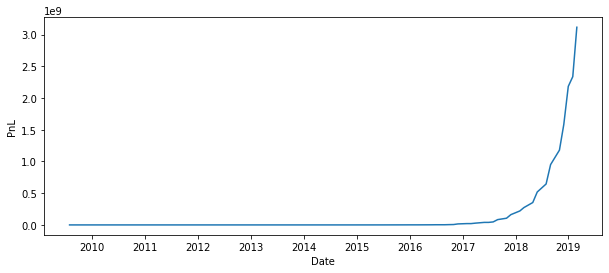

sharpe ratio 2.6909, annual return 1.9432, mdd 0.0000

equal weighted, market neutral


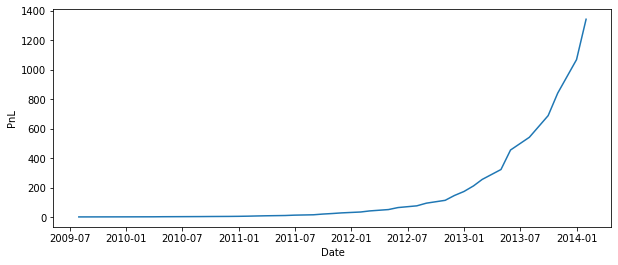

sharpe ratio nan, annual return inf, mdd 0.0000

alpha weighted, industry neutral


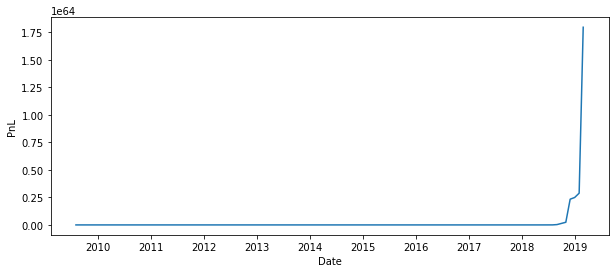

sharpe ratio 2.4907, annual return 1488.5351, mdd 0.0000

equal weighted, industry neutral


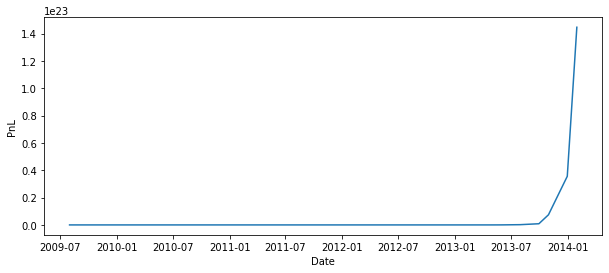

sharpe ratio nan, annual return inf, mdd 0.0000



In [11]:
fake_alpha = backtest_data.rename(columns={'Rtn1q': 'alpha'})
backtest.set_alpha(fake_alpha)
backtest.print_results()

In [12]:
alpha_generator = alpha_generate(model_data, factors, rtn_type, model)

In [13]:
train_begin = '2010-01-01'
train_end = '2017-12-31'
test_begin = '2018-01-01'
test_end = '2019-12-31'

In [14]:
train_alpha, train_R_2 = alpha_generator.Train(train_begin, train_end)
train_R_2

ValueError: The parameter loc has invalid values
           Trace Shapes:            
            Param Sites:            
           Sample Sites:            
 module$$$h0.weight dist     | 10 19
                   value     | 10 19
   module$$$h0.bias dist     | 10   
                   value     | 10   
module$$$out.weight dist     |  1 10
                   value     |  1 10
  module$$$out.bias dist     |  1   
                   value     |  1   
              sigma dist     |      
                   value   1 |      
               data dist     |      
                   value 128 |      

In [ ]:
backtest.set_alpha(train_alpha)
backtest.print_results()

In [ ]:
test_alpha, test_R_2 = alpha_generator.Test(test_begin, test_end)
test_R_2

In [ ]:
backtest.set_alpha(test_alpha)
backtest.print_results()